##Setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from showit import image, tile
import matplotlib.animation as animation

In [4]:
from os.path import join, exists
from os import mkdir, makedirs

In [5]:
import thunder

In [6]:
from registration import CrossCorr

##Set directory and session information

In [7]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [8]:
key = '2016-04-01'
name = 'anm-0326049'

In [9]:
path = join(directory, 'reprocessed', name, key)

##Load data

In [10]:
data = thunder.images.frombinary(join(path, 'images'), engine=sc)

In [11]:
data

Images
mode: spark
dtype: int16
shape: (11769, 4, 512, 512)

##Register data

In [12]:
reference = data[:30].mean().toarray()

In [13]:
algorithm = CrossCorr(axis=0)

In [14]:
model = algorithm.fit(data, reference)

In [15]:
registered = model.transform(data)

In [16]:
registered

Images
mode: spark
dtype: int16
shape: (11769, 4, 512, 512)

##Inspect shifts

In [18]:
shifts = model.toarray()

In [19]:
shifts.shape

(11769, 4, 2)

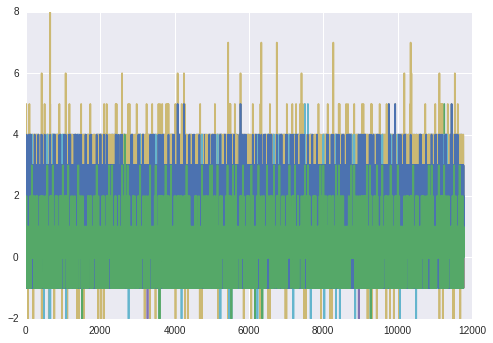

In [20]:
[plt.plot(model.toarray()[:,i,:]) for i in range(shifts.shape[1])];

##Inspect data

In [21]:
mean = registered.mean().toarray()

In [22]:
mean.shape

(4, 512, 512)

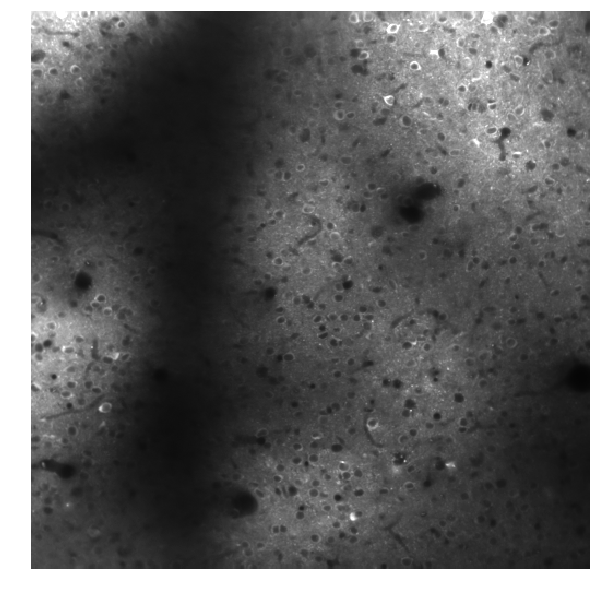

In [23]:
img = mean[0,:,:]
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(img, clim=(0, 3.5*img.mean()), ax=ax)

##Save registered binary data

In [24]:
savepath = join(directory, 'reprocessed', name, key, 'registered')
if not exists(savepath):
    makedirs(savepath)

In [25]:
registered.tobinary(savepath, overwrite=True)

##Save summary data

In [29]:
savepath = join(directory, 'reprocessed', name, key, 'summary')
if not exists(savepath):
    makedirs(savepath)

###Raw tiffs

In [30]:
from skimage.io import imsave

In [32]:
imsave(savepath+'/registered.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')
imsave(savepath+'/reference.tif', reference.astype('float32'), plugin='tifffile', photometric='minisblack')

###Normalized tiffs

In [33]:
def normalize(oim):
    # normalizes 3D image across first axis
    assert oim.ndim == 3
    
    means = oim.mean(axis=(1, 2), dtype='float32')
    maximum = means.max()
    return array([oim[i]*maximum/means[i] for i in range(oim.shape[0])])

In [34]:
imsave(savepath+'/registered-norm.tif', normalize(mean).astype('float32'), plugin='tifffile', photometric='minisblack')
imsave(savepath+'/reference-norm.tif', normalize(reference).astype('float32'), plugin='tifffile', photometric='minisblack')